In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# DATA UNDERSTANDING

**1) Loading the Dataset**

In [2]:
df1 = pd.read_excel("../data/PSP_Jan_Feb_2019.xlsx")
print("Number of rows and Columns: ", df1.shape)
df1.head()

Number of rows and Columns:  (50410, 8)


Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners

In [3]:
for col in ['country','success', 'PSP', '3D_secured', 'card']:
   print(col,":", df1[col].unique()," - ", df1[col].nunique())

country : ['Germany' 'Austria' 'Switzerland']  -  3
success : [0 1]  -  2
PSP : ['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']  -  4
3D_secured : [0 1]  -  2
card : ['Visa' 'Diners' 'Master']  -  3


In [4]:
# Ignoring column 'Unnamed: 0' as it is merely the serial number of the records and is of no use
df1.drop(["Unnamed: 0"], axis=1, inplace=True)
print(df1.columns)
display(df1.head())


Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')


tmsp  country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11  Germany      89        0     UK_Card           0   
1 2019-01-01 00:01:17  Germany      89        1     UK_Card           0   
2 2019-01-01 00:02:49  Germany     238        0     UK_Card           1   
3 2019-01-01 00:03:13  Germany     238        1     UK_Card           1   
4 2019-01-01 00:04:33  Austria     124        0  Simplecard           0   

     card  
0    Visa  
1    Visa  
2  Diners  
3  Diners  
4  Diners

In [5]:
#Loading the PSP transaction fees data as a dataFrame
df2 = pd.DataFrame({"PSP":["Moneycard","Goldcard","UK_Card","Simplecard"], 
                    "success_txnFee":[5,10,3,1],
                    "failure_txnFee":[2,5,1,0.5]
                   })
display(df2.head())

PSP  success_txnFee  failure_txnFee
0   Moneycard               5             2.0
1    Goldcard              10             5.0
2     UK_Card               3             1.0
3  Simplecard               1             0.5

**2) Data Quality Analysis**

**i) Checking the descriptive statistics of numerical features in the dataset**

In [6]:
df1.describe()

amount       success    3D_secured
count  50410.000000  50410.000000  50410.000000
mean     202.395715      0.202896      0.238266
std       96.274730      0.402160      0.426027
min        6.000000      0.000000      0.000000
25%      133.000000      0.000000      0.000000
50%      201.000000      0.000000      0.000000
75%      269.000000      0.000000      0.000000
max      630.000000      1.000000      1.000000

**ii) Checking the datatypes of each feature**

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


**iii) Checking existence of missing values**

In [8]:
df1.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

# DATA PREPARATION

**1) Data cleaning**

**Checking duplicate entries in the dataset**

In [9]:
print("Total record count: ",df1.shape[0])
print("Duplicate count: ",df1[df1.duplicated()].shape[0])
# Removing the duplicate records from the dataset
df1.drop_duplicates(inplace=True) 
print("Record count after removing duplicates: ", df1.shape[0])

Total record count:  50410
Duplicate count:  81
Record count after removing duplicates:  50329


**2) Data Integration**

In [10]:
#Merging both the dataframes into a single dataframe based on the PSP 
df3 = pd.merge(df1,df2, on = "PSP")
df3.sample(5)

tmsp      country  amount  success         PSP  \
2634  2019-01-05 07:41:52  Switzerland      99        1     UK_Card   
47481 2019-01-06 22:38:37      Germany      98        0    Goldcard   
49171 2019-02-07 07:56:03      Germany     101        1    Goldcard   
28036 2019-01-07 15:49:03      Germany     232        0  Simplecard   
39441 2019-01-04 08:55:32      Germany     221        0   Moneycard   

       3D_secured    card  success_txnFee  failure_txnFee  
2634            1    Visa               3             1.0  
47481           0  Master              10             5.0  
49171           1    Visa              10             5.0  
28036           0    Visa               1             0.5  
39441           0    Visa               5             2.0

**3) Data Construction and Transformation**

**i) Calculating number of transaction attempts**

As our business witnesses a significant number of failed transactions on the first attempt, it is advisable to calculate the number of transaction attempts made by customers to transfer money. Information from the business side suggests that, if two transactions are within one minute, with the same amount of money and from the same country, it is (for a decent number of tries) safe to assume that they are payment attempts of the same purchase

In [11]:
df3["tmsp"] = pd.to_datetime(df3["tmsp"])
# Sorting the dataframe by the timestamp in ascending order
df3.sort_values(["tmsp"], inplace=True) 

# Finding the difference between consecutive timestamps 
df3["tmsp_diff"] = df3["tmsp"] - df3["tmsp"].shift(1) 
df3.reset_index(inplace=True)
df3.drop(["index"], axis=1, inplace=True)

#Converting the timedelta (difference) into seconds
df3["tmsp_diff"]  = df3["tmsp_diff"].apply(lambda x: x.total_seconds())

# Assigning a value 1 if the transaction is done within a minute after the previous transaction, or 0 otherwise
df3["withinMinute"] =  df3["tmsp_diff"].apply(lambda x: 1 if x<=60 else 0)

# Introducing a feature ‘noOfAttempts’ which captures the number of transaction attempts based on the given criteria and assigning an initial value of 1 for all records
df3["noOfAttempts"] = 1

# Incrementing the 'noOfAttempts' consequently if withinMinute = 1
for i, r in df3.iterrows():
     if i< df3.shape[0]-1:
          if (df3["country"][i] == df3["country"][i+1]) & (df3["amount"][i] == df3["amount"][i+1]) & (df3["withinMinute"][i+1]<=60):
            df3["noOfAttempts"][i+1] = df3["noOfAttempts"][i] + 1
df3.tail()

tmsp      country  amount  success        PSP  \
50324 2019-02-28 23:45:39  Switzerland     415        0    UK_Card   
50325 2019-02-28 23:46:48      Austria      91        0    UK_Card   
50326 2019-02-28 23:47:04      Austria      91        0    UK_Card   
50327 2019-02-28 23:47:36      Austria      91        0    UK_Card   
50328 2019-02-28 23:48:19      Austria      91        1  Moneycard   

       3D_secured    card  success_txnFee  failure_txnFee  tmsp_diff  \
50324           0    Visa               3             1.0      123.0   
50325           0  Master               3             1.0       69.0   
50326           0  Master               3             1.0       16.0   
50327           0  Master               3             1.0       32.0   
50328           0  Master               5             2.0       43.0   

       withinMinute  noOfAttempts  
50324             0             1  
50325             0             1  
50326             1             2  
50327             1             3  
50328             1             4

**ii) Extracting the month, day, hour and weekday from the timestamp** 

This step helps to analyse if the success rate is of PSPs is dependent on any particular period 

In [12]:
# Creating a new column called Month
df3['Month'] = df3['tmsp'].dt.month 

# Creating a new column called Day
df3['Day'] = df3['tmsp'].dt.day     

# Creating a new column called Hour
df3['Hour'] = df3['tmsp'].dt.hour 

# Creating a new column called Weekday with sunday as 6 and monday as 0
df3["Weekday"] = df3['tmsp'].dt.dayofweek
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df3['Weekday'] = df3['Weekday'].map(day_mapping)

df3.head()

tmsp  country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11  Germany      89        0     UK_Card           0   
1 2019-01-01 00:01:17  Germany      89        1     UK_Card           0   
2 2019-01-01 00:02:49  Germany     238        0     UK_Card           1   
3 2019-01-01 00:03:13  Germany     238        1     UK_Card           1   
4 2019-01-01 00:04:33  Austria     124        0  Simplecard           0   

     card  success_txnFee  failure_txnFee  tmsp_diff  withinMinute  \
0    Visa               3             1.0        NaN             0   
1    Visa               3             1.0        6.0             1   
2  Diners               3             1.0       92.0             0   
3  Diners               3             1.0       24.0             1   
4  Diners               1             0.5       80.0             0   

   noOfAttempts  Month  Day  Hour  Weekday  
0             1      1    1     0  Tuesday  
1             2      1    1     0  Tuesday  
2             1      1    1     0  Tuesday  
3             2      1    1     0  Tuesday  
4             1      1    1     0  Tuesday

**iii) Encoding Categorical Features**

In [13]:
import copy
df3["tmsp_diff"] = df3["tmsp_diff"].fillna(0)
df3.drop(['tmsp_diff', 'withinMinute'], axis=1, inplace=True)

#LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
df4 = copy.deepcopy(df3)
categorical_cols = ["country","PSP", "card","Weekday"]
label_encoder = LabelEncoder()
for col in categorical_cols:
        df4[col] = label_encoder.fit_transform(df4[col])
        print(col,":", label_encoder.classes_)
df4.sample(5) 

country : ['Austria' 'Germany' 'Switzerland']
PSP : ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
card : ['Diners' 'Master' 'Visa']
Weekday : ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


tmsp  country  amount  success  PSP  3D_secured  card  \
7835  2019-01-08 16:08:41        1     356        0    3           0     1   
36768 2019-02-12 00:11:56        0     193        0    1           0     2   
46156 2019-02-23 16:32:42        0     193        0    2           0     2   
48624 2019-02-26 21:58:32        1      78        0    3           0     1   
3635  2019-01-04 02:28:54        0     199        0    1           0     1   

       success_txnFee  failure_txnFee  noOfAttempts  Month  Day  Hour  Weekday  
7835                3             1.0             6      1    8    16        5  
36768               5             2.0             2      2   12     0        5  
46156               1             0.5             5      2   23    16        2  
48624               3             1.0             3      2   26    21        5  
3635                5             2.0             1      1    4     2        0

In [14]:
# ONE-HOT ENCODING     
df5 = copy.deepcopy(df3)
# Using drop_first=True to drop the redundant column 
# df5.drop(["Weekday"], axis=1 ,inplace=True)
categorical_cols = ["country", "PSP","card", "Weekday"]
df5 = pd.get_dummies(df5, columns=categorical_cols, drop_first=True)

# Display the resulting DataFrame
print(df5.shape)
df5.head()

(50329, 23)


tmsp  amount  success  3D_secured  success_txnFee  \
0 2019-01-01 00:01:11      89        0           0               3   
1 2019-01-01 00:01:17      89        1           0               3   
2 2019-01-01 00:02:49     238        0           1               3   
3 2019-01-01 00:03:13     238        1           1               3   
4 2019-01-01 00:04:33     124        0           0               1   

   failure_txnFee  noOfAttempts  Month  Day  Hour  ...  PSP_Simplecard  \
0             1.0             1      1    1     0  ...               0   
1             1.0             2      1    1     0  ...               0   
2             1.0             1      1    1     0  ...               0   
3             1.0             2      1    1     0  ...               0   
4             0.5             1      1    1     0  ...               1   

   PSP_UK_Card  card_Master  card_Visa  Weekday_Monday  Weekday_Saturday  \
0            1            0          1               0                 0   
1            1            0          1               0                 0   
2            1            0          0               0                 0   
3            1            0          0               0                 0   
4            0            0          0               0                 0   

   Weekday_Sunday  Weekday_Thursday  Weekday_Tuesday  Weekday_Wednesday  
0               0                 0                1                  0  
1               0                 0                1                  0  
2               0                 0                1                  0  
3               0                 0                1                  0  
4               0                 0                1                  0  

[5 rows x 23 columns]

# DATA VISUALIZATION (EDA)

**Visualising the problem statement**

In [15]:
first_attempt_df = df3[df3["noOfAttempts"]==1][["success"]].value_counts().reset_index(name = "TransactionCount")

display(first_attempt_df)

fig = px.bar(first_attempt_df, x='success', y='TransactionCount', text='TransactionCount',
             labels={'success': 'Transaction Status', 'TransactionCount': 'Transaction Count'},
             title='Transaction Status of first payment attempt by user')

fig.update_traces(texttemplate='%{text}', textposition='outside')

# Update x-axis tick labels using dictionary
labels = {0: 'Failed', 1: 'Successful'}
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext = [labels[0], labels[1]]
    ),
    title={
        'x': 0.5  # Center title
    }
)
fig.show()

success  TransactionCount
0        0             21639
1        1              5653

**As we can see in the graph, only around 26% transactions (5653) have been successful in the very first attempt by the user. 
Not all users would be willing to make multiple attempts at the payment. Payment failures can be very frustating for users 
and turn out to be potential cause for customer churn and hence business loss.This scenario leads to a compelling 
need to analyse the cause of transaction failures and utilize machine learning models to predict 
PSP(Payment Service Providers) that increase the success rate of transactions.**

**1) Exploring Variations in Transaction Trends by Country**

In [16]:
# Grouping the data records based on country and success columns to get the total count of failed and successful transactions in each country

countrywise_success_txns = df3.groupby(["country","success"])[["tmsp"]].count().reset_index()
countrywise_success_txns.rename(columns={"tmsp":"TransactionCount"}, inplace=True)
countrywise_success_txns["success"] = countrywise_success_txns['success'].astype(str)
display(countrywise_success_txns)

# Using Plotly bar chart to visualize
color_map = {'0': 'red', '1': 'green'}
fig = px.bar(countrywise_success_txns, x='country', y='TransactionCount',
             text='TransactionCount',
             barmode='group',
             color='success',
             color_discrete_map = color_map,
             labels={'country': 'country', 'TransactionCount': 'Transaction Count'},
             title='Success and Failure Transactions in each country')
fig.update_layout(xaxis_type='category')
fig.show()


country success  TransactionCount
0      Austria       0              7808
1      Austria       1              2013
2      Germany       0             24096
3      Germany       1              6088
4  Switzerland       0              8197
5  Switzerland       1              2127

**We can see that Germany has the highest number of transactions denoting that the business has a strong stance in Germany.
The number of transactions in Austria and Switzerland are approximately similar to each other, though they are much lesser in comparison to Germany. Due to this imbalance, looking at the success transaction counts will lead to a biased insight. Analysing the transactions in terms of success rates would be a better perspective.**

**2) Enhancing Insights: Average Success Rates Across PSPs, Cards and Countries**


In [17]:
#Calculating Avg success rates
df3["psp_success_rate"]=df3.groupby(['PSP'])[['success']].transform('mean')
df3["card_success_rate"]=df3.groupby(['card'])[['success']].transform('mean')
df3["country_success_rate"]=df3.groupby(['country'])[['success']].transform('mean')


#Creating tables for PSPs, cards, countries and their success rates
rates = df3[["PSP","card","country","psp_success_rate","card_success_rate","country_success_rate"]]
psp_success_rate_df = rates.groupby(["PSP"])[["psp_success_rate"]].mean().reset_index()
card_success_rate_df = rates.groupby(["card"])[["card_success_rate"]].mean().reset_index()
country_success_rate_df = rates.groupby(["country"])[["country_success_rate"]].mean().reset_index()

display(psp_success_rate_df)
display(card_success_rate_df)
display(country_success_rate_df)


#Plotting the success rates
trace_A = go.Bar(x=psp_success_rate_df['PSP'], y=psp_success_rate_df['psp_success_rate'], name='Txn Success Rate by PSPs', marker_color='blue', text=psp_success_rate_df["psp_success_rate"])
trace_B = go.Bar(x=card_success_rate_df['card'], y=card_success_rate_df['card_success_rate'], name='Txn Success Rate by Cards', marker_color='green', text=card_success_rate_df["card_success_rate"])
trace_C = go.Bar(x=country_success_rate_df['country'], y=country_success_rate_df['country_success_rate'], name='Txn Success Rate by Country', marker_color='orange', text=country_success_rate_df["country_success_rate"])

#Creating subplots
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=("Success Rate by PSPs", "Success Rate by Cards","Success Rate by Country"))

fig.add_trace(trace_A, row=1, col=1)
fig.add_trace(trace_B, row=1, col=2)
fig.add_trace(trace_C, row=1, col=3)

fig.update_layout(showlegend=False)
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()

PSP  psp_success_rate
0    Goldcard          0.406172
1   Moneycard          0.218833
2  Simplecard          0.158212
3     UK_Card          0.194861

card  card_success_rate
0  Diners           0.223247
1  Master           0.194252
2    Visa           0.208756

country  country_success_rate
0      Austria              0.204969
1      Germany              0.201696
2  Switzerland              0.206025

**As the data provided has imbalance w.r.t categorical variables like country, card and PSP, it is better to look at the average success rate rather than the number of success transactions, in order to get a better picture of the business. The above graphs represent the overall average transaction success rate for each PSP (left), each card (center) and each country (right).**

**3) Comparing Average Transaction Success Rates Across PSPs and Countries**

In [18]:
#  Country wise PSP Success Rate  :
success_rate_by_psp = df3.groupby(['PSP','country'])['success'].mean().reset_index()
fig = px.bar(success_rate_by_psp, x='PSP', y='success', text='success', barmode='group', labels={'success': 'Success Rate'}, color='country')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(title='Country-wise PSP Success Rates', xaxis_title='PSP', yaxis_title='Success Rate')
fig.show()

**We can see that the transaction success rate is higher in Austria followed by Switzerland for the PSPs Goldcard and Moneycard. Whereas the success rate is nearly similar for all the countries in case of Simplecard and UK_Card.**

**4) PSP Performance by Card Type: Success and Failure Rates**

**Evaluating the success and failure rates of different 'PSPs' for each 'card' type might showcase if a specific 'PSP' performs better or worse with particular card networks.**

In [19]:
card_PSP = df3.groupby(["card","PSP"])[["success_txnFee","failure_txnFee"]].sum().reset_index()
card_PSP

fee_summary = card_PSP.melt(id_vars=['card', 'PSP'], value_vars=['success_txnFee', 'failure_txnFee'],
                      var_name='Transaction Type', value_name='Total Fee')
display(fee_summary.sample(5))
# Plotting grouped bar chart for total success and failure transaction fees by PSP grouped by Card
fig = px.bar(fee_summary, x='card', y='Total Fee', color='Transaction Type', facet_col='PSP', barmode='group',
             labels={'Total Fee': 'Total Fee', 'card': 'Card', 'PSP': 'PSP'},
             title='Total Success and Failure Transaction Fees by PSP grouped by Card')

fig.show()

card         PSP Transaction Type  Total Fee
0   Diners    Goldcard   success_txnFee     6700.0
10    Visa  Simplecard   success_txnFee     2842.0
23    Visa     UK_Card   failure_txnFee     6144.0
2   Diners  Simplecard   success_txnFee     2356.0
18  Master  Simplecard   failure_txnFee     3620.5

**It's evident that ‘Master’ card is the most commonly used for transactions, followed by ‘Visa’ and ‘Diners’. Notably, the 'UK_Card' PSP has generated the highest transaction fees through Mastercard, followed by 'Moneycard' and 'Goldcard'.**

**5) Comparing Transaction Fee Collection by Different Payment Service Providers (PSPs)**

In [20]:
#Calculating total success and failure transaction fees collected by each PSP
success_fee = df3.loc[df3['success']==1].groupby('PSP')['success_txnFee'].sum().reset_index()
failure_fee = df3.loc[df3['success']==0].groupby('PSP')['failure_txnFee'].sum().reset_index()

# Merging the two sums for success and failure into a single DataFrame
fee_summary = pd.merge(success_fee, failure_fee, on='PSP', how='outer').fillna(0)
fee_summary.columns = ['PSP', 'Success Fee', 'Failure Fee']
fee_summary["total_txn_fee"] = fee_summary["Success Fee"] +fee_summary["Failure Fee"]
display(fee_summary.sort_values(["Failure Fee"], ascending=False))

#Comparing the total fee collection by each PSP
fig = px.bar(fee_summary, x='PSP', y=['total_txn_fee'],
             barmode='group', labels={'value': 'Total Fees', 'PSP': 'PSP'},
             title='Total Transaction Fee collection by PSP')
fig.update_traces(marker_color='blue')
fig.show()

PSP  Success Fee  Failure Fee  total_txn_fee
3     UK_Card        15426      21246.0        36672.0
1   Moneycard         9075      12958.0        22033.0
0    Goldcard        13030       9525.0        22555.0
2  Simplecard         1968       5235.5         7203.5

**Despite having nominal fees for both successful and failed transactions per payment, the UK_Card provider stands out with the highest total transaction fees collected, reaching approximately 36,000 Euros. However, it is essential to acknowledge that this insight might be biased, given that the dataset predominantly features transactions through the UK_Card PSP as seen in the subsequent bar chart.**

**Total Transactions via each PSP**

In [21]:
# Processing data to get transaction counts by PSP
psp_transactions = df3["PSP"].value_counts().reset_index()
psp_transactions.rename(columns={"index":"PSP", "PSP":"TransactionCount"}, inplace=True)

# Plotting bar graph to visualize total transactions via each PSP 
fig = px.bar(psp_transactions, x='PSP', y='TransactionCount',
             title='Total Transactions via each PSP', 
             text='TransactionCount',  
             labels={'TransactionCount': 'Transaction Count'})

fig.update_traces(marker_color='orange',texttemplate='%{text}', textposition='outside')
fig.show()

In [22]:
# Plotting grouped bar chart for total success and failure transaction fees by PSP
fig = px.bar(fee_summary, x='PSP', y=['Success Fee', 'Failure Fee'],
             barmode='group', labels={'value': 'Total Fees', 'PSP': 'PSP'},
             title='Total Success and Failure Transaction Fee collection by PSP')

fig.show()

**6) Visualizing trend of Successful transactions of PSPs over every hour and every weekday**

In [23]:
# Filtering successful transactions
successful_transactions = df3[df3['success'] == 1]

# Grouping successful transactions by hour and counting occurrences
success_by_hour = successful_transactions.groupby(['Hour',"PSP"]).size().reset_index(name='count')

# Plotting the trend of successful transactions over each hour of a day
fig = px.line(success_by_hour, x='Hour', y='count', color='PSP', 
              labels={'count': 'Successful Transaction Count', 'Hour': 'Hour of the day', 'PSP': 'PSP'},
              title='Trend of Successful Transactions by PSPs Over Each Hour')

fig.show()

In [24]:
# Grouping successful transactions by weekday and counting occurrences
success_df = successful_transactions.groupby(['Weekday',"PSP"]).size().reset_index(name='count')
fig = px.line(success_df, x='Weekday', y='count', color='PSP', 
              labels={'count': 'Successful Transaction Count', 'Weekday': 'Day of the Week', 'PSP': 'PSP'},
              title='Trend of Successful Transactions by PSPs Over Each weekday')
fig.show()

**7) Transaction Amount Distribution**

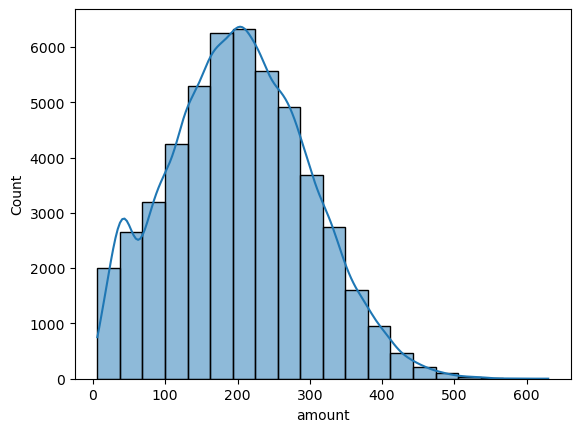

In [25]:
#Plotting histogram for transaction amounts
sns.histplot(df3, x='amount', bins=20, kde=True)
plt.show()

**8) Number of Attempts vs Avgerage Transaction Success Rate**

- **This visualization helps in understanding how the success of a transaction correlates with the number of attempts made.**
- **Understanding the success rate pattern can reveal behavioral trends. For example, a consistent high success rate at a certain attempt number might imply a common scenario where users are more likely to succeed after a specific number of attempts.**

In [26]:
# Grouping by 'number of attempts' and calculating the mean success rate
success_rate = df3.groupby('noOfAttempts')['success'].mean().reset_index()

# Plotting the success rate vs. number of attempts using Plotly
fig = px.bar(success_rate, x='noOfAttempts', y='success', 
             labels={'success': 'Avg Success Rate', 'noOfAttempts': 'Number of Attempts'}, 
             title='Success Rate vs. Number of Attempts')

fig.update_layout(xaxis_type='category')

fig.show()

**With the given data of 2-months period, there seems to be no correlation between the success rate and the number of attempts**

**9) Transaction Success over Time:**

In [27]:
# Set 'tmsp' as the DataFrame index
timedf = df3.set_index('tmsp')

# Resample data daily and calculate the daily success rate
daily_success_rate = timedf['success'].resample('D').mean().reset_index()

# Then, create the plot using Plotly
fig = px.line(daily_success_rate, x='tmsp', y='success', title='Daily Transaction Success Rate')
fig.update_layout(xaxis_title='Date', yaxis_title='Success Rate')
fig.show()

**Card Provider Distribution**

In [28]:
card_provider_distribution = df3['card'].value_counts().reset_index()
fig = px.bar(card_provider_distribution, x='index', y='card', text='card')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(title='Credit Card Provider Distribution', xaxis_title='Card Provider', yaxis_title='Frequency')
fig.show()

**10) 3D Secure vs. Non-3D Secure Transactions:**

In [29]:
fig = px.bar(df1['3D_secured'].value_counts().reset_index(), x='index', y='3D_secured', text='3D_secured')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(title='3D Secure vs. Non-3D Secure Transactions', xaxis_title='3D Secured', yaxis_title='Count')
fig.show()

**11) Distribution of Transaction Amounts by Success/Failure**

In [30]:
fig = px.violin(df1, y='amount', x='success', box=True, points="all",
                labels={'amount': 'Transaction Amount', 'success': 'Transaction Result'},
                title='Distribution of Transaction Amounts by Success/Failure')

fig.show()

- **The width of the violin indicates the density or frequency of transaction amounts within that category.** 
- **A wider section suggests a higher frequency of amounts in that range.**
- **It helps to visualize if there are notable differences or similarities in the amount distributions between successful and failed transactions.**
- **We can see that the amount distribution is similar for both success and failure transactions.**

**12) Correlation Matrix between attributes**

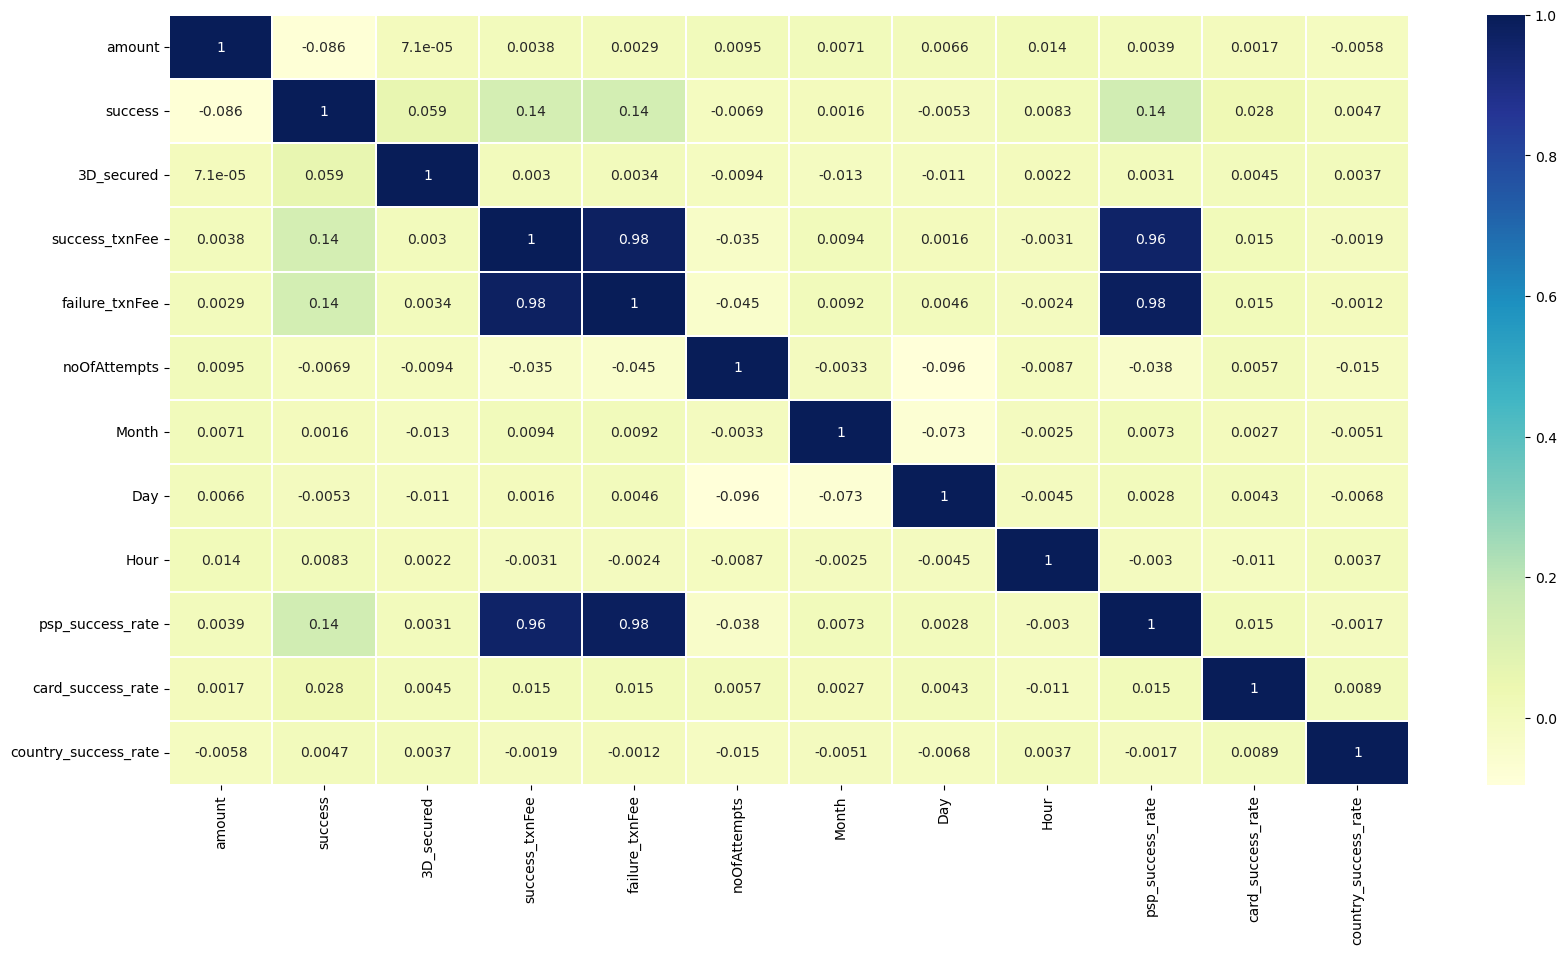

In [31]:
plt.figure(figsize=(20,10))
sns.heatmap(df3.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.show()

In [32]:
# df4.to_csv("../data/pre-processed_data/df4.csv", index=False)
# df5.to_csv("../data/pre-processed_data/df5.csv", index=False)

# MODELLING 

In [33]:
features = df4.drop(["tmsp","success",'Month'],axis=1)
target = df4['success']

# RANDOM OVER SAMPLER

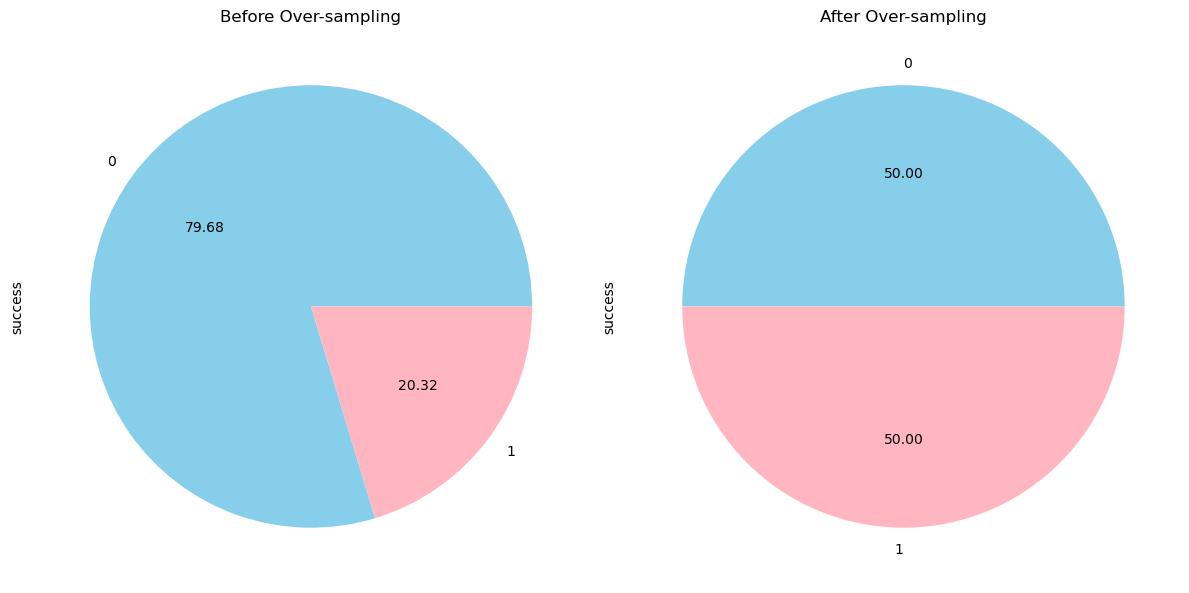

In [34]:
from imblearn.over_sampling import RandomOverSampler

# RANDOM OVER SAMPLER to handle class imbalance
ros = RandomOverSampler(sampling_strategy="not majority", random_state=7)
X_res, y_res = ros.fit_resample(features, target)

#Plotting the class ratio
colors = ['skyblue', 'lightpink']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Before Over-sampling
ax1 = target.value_counts().plot.pie(autopct='%.2f', ax=axes[0],colors=colors)
ax1.set_title("Before Over-sampling")

# Plot 2: After Over-sampling
ax2 = y_res.value_counts().plot.pie(autopct='%.2f', ax=axes[1], colors=colors)
ax2.set_title("After Over-sampling")
plt.tight_layout()
plt.show()



In [35]:
print(y_res.value_counts())

0    40101
1    40101
Name: success, dtype: int64


# BASELINE MODEL : LOGISTIC REGRESSION

In [36]:
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Creating and fitting a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predicting on the test set
y_pred = logreg.predict(X_test)


In [37]:
# EVALUATING METRICS AND PLOTTING 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report 

def metrics_and_plots(model):
     # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.2f}")

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.2f}\n")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",conf_matrix,"\n")
    
    #Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Predict probabilities for positive class (success) for the test set
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, probs)
    print(f"\nAUC Score: {auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random Guess Line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Create Calibration Plot
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.figure(figsize=(6, 4))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Plot')
    plt.plot([0, 1], [0, 1], 'k--')  # Perfectly Calibrated Line
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()

Evaluating Baseline Classifier Model - Random Forest:

Accuracy: 0.57
Precision: 0.58
Recall: 0.54
F1 Score: 0.56

Confusion Matrix:
 [[4901 3067]
 [3753 4320]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.62      0.59      7968
           1       0.58      0.54      0.56      8073

    accuracy                           0.57     16041
   macro avg       0.58      0.58      0.57     16041
weighted avg       0.58      0.57      0.57     16041


AUC Score: 0.61


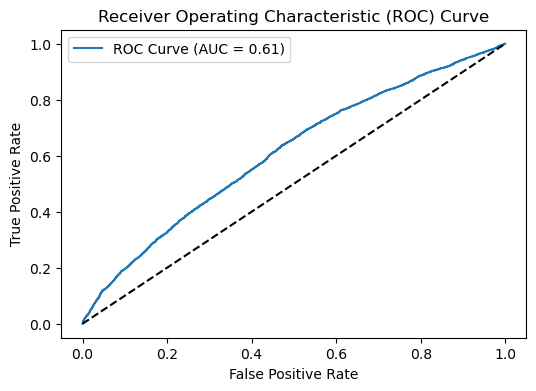

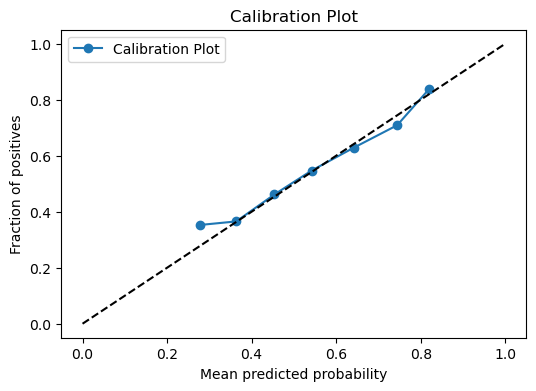

In [38]:
# Print metrics
print("Evaluating Baseline Classifier Model - Random Forest:\n")
metrics_and_plots(logreg)

# RANDOM FOREST MODEL

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#Creating and fitting the Random Forest Classifier
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train, y_train)

#Predicting on the test set
y_pred = rf.predict(X_test)

In [40]:
# import pickle
# # Save the model to a file using pickle
# with open('../models/random_forest_model.pkl', 'wb') as model_file:
#     pickle.dump(rf, model_file)

Evaluating Accurate Classifier Model - Random Forest:

Accuracy: 0.92
Precision: 0.89
Recall: 0.97
F1 Score: 0.93

Confusion Matrix:
 [[6980  988]
 [ 239 7834]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      7968
           1       0.89      0.97      0.93      8073

    accuracy                           0.92     16041
   macro avg       0.93      0.92      0.92     16041
weighted avg       0.93      0.92      0.92     16041


AUC Score: 0.98


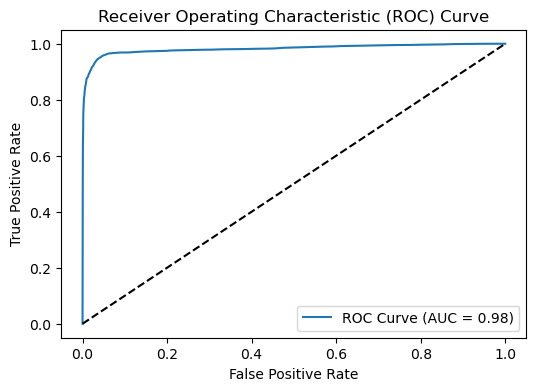

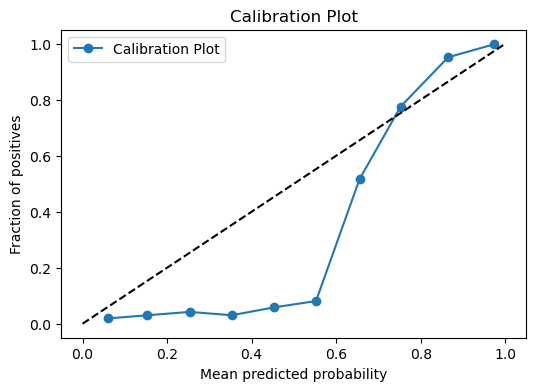

In [41]:
# Print metrics
print("Evaluating Accurate Classifier Model - Random Forest:\n")
metrics_and_plots(rf)

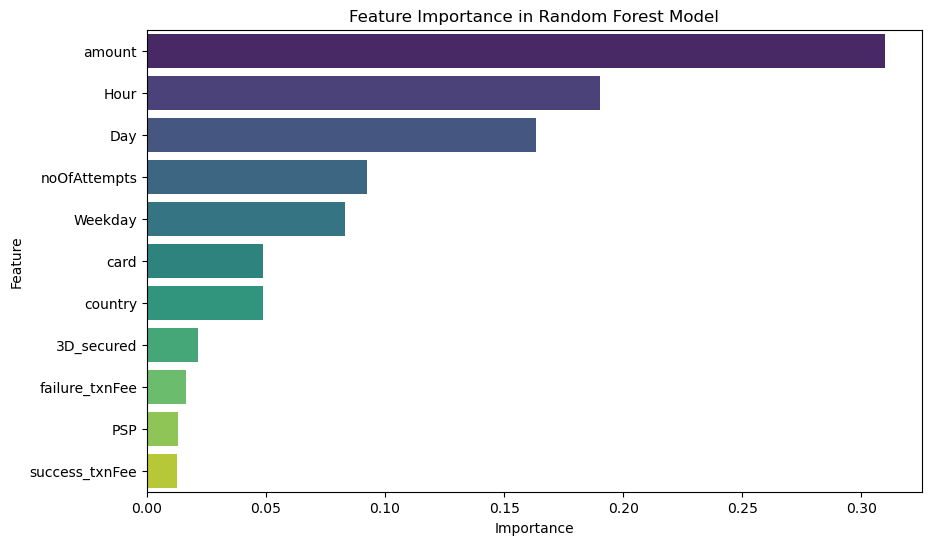

In [42]:
rf.feature_importances_
feature_importance = rf.feature_importances_
feature_names = X_res.columns 

# Creating a DataFrame for better visualisation
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sorting the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [43]:
# Order of classes
print(rf.classes_)

# Random Forest Model predictions on the test dataset
predicted_probabilities = rf.predict_proba(X_test)
print(predicted_probabilities)

[0 1]
[[0.9  0.1 ]
 [0.21 0.79]
 [0.19 0.81]
 ...
 [0.81 0.19]
 [0.61 0.39]
 [1.   0.  ]]


In [44]:
X_test

country  amount  PSP  3D_secured  card  success_txnFee  failure_txnFee  \
41893        1     123    2           0     1               1             0.5   
58111        2     294    1           1     1               5             2.0   
18903        0     224    0           0     1              10             5.0   
69950        1     179    3           0     2               3             1.0   
75918        1     346    2           1     1               1             0.5   
...        ...     ...  ...         ...   ...             ...             ...   
33524        2     188    0           0     0              10             5.0   
78155        1     258    3           0     1               3             1.0   
14528        1     267    1           0     0               5             2.0   
49838        2      37    3           1     0               3             1.0   
13058        1     232    3           0     1               3             1.0   

       noOfAttempts  Day  Hour  Weekday  
41893             4   18     7        1  
58111             1   11    13        1  
18903             1   22     9        5  
69950             1   21    20        1  
75918             2   29    17        5  
...             ...  ...   ...      ...  
33524             2    8     0        0  
78155             1    2    14        6  
14528             1   16    16        6  
49838             2   28     9        4  
13058             1   15     0        5  

[16041 rows x 11 columns]

In [45]:
X_test.reset_index(inplace=True)
X_test.drop(["index"], axis=1, inplace=True)

In [46]:
X_test.head()

country  amount  PSP  3D_secured  card  success_txnFee  failure_txnFee  \
0        1     123    2           0     1               1             0.5   
1        2     294    1           1     1               5             2.0   
2        0     224    0           0     1              10             5.0   
3        1     179    3           0     2               3             1.0   
4        1     346    2           1     1               1             0.5   

   noOfAttempts  Day  Hour  Weekday  
0             4   18     7        1  
1             1   11    13        1  
2             1   22     9        5  
3             1   21    20        1  
4             2   29    17        5

In [47]:
# a

**Deriving Success Probabilities for Transactions Across Different PSPs**

In [48]:
def get_predictions(row, psp_value):
    modified_row = row.copy()
    modified_row['PSP'] = psp_value
    return rf.predict_proba([modified_row])[0]

# Iterate over each row in X_test
results = []
for index, row in X_test.iterrows():
    original_psp = row['PSP']
    predictions = list(map(lambda psp_value: (psp_value, get_predictions(row, psp_value)), range(4)))
    results.append({'Original_Index': index,'Predicted_Probabilities': predictions})

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Merge the result DataFrame with the original X_test
result_df = pd.merge(X_test, result_df, left_index=True, right_on='Original_Index')

# Display the result DataFrame
display(result_df.head())

# Extracting the predicted probabilities for the transaction at 0th index in the test dataset
probability_list = result_df.loc[0,"Predicted_Probabilities"]
print(probability_list)


country  amount  PSP  3D_secured  card  success_txnFee  failure_txnFee  \
0        1     123    2           0     1               1             0.5   
1        2     294    1           1     1               5             2.0   
2        0     224    0           0     1              10             5.0   
3        1     179    3           0     2               3             1.0   
4        1     346    2           1     1               1             0.5   

   noOfAttempts  Day  Hour  Weekday  Original_Index  \
0             4   18     7        1               0   
1             1   11    13        1               1   
2             1   22     9        5               2   
3             1   21    20        1               3   
4             2   29    17        5               4   

                             Predicted_Probabilities  
0  [(0, [0.85, 0.15]), (1, [0.91, 0.09]), (2, [0....  
1  [(0, [0.25, 0.75]), (1, [0.21, 0.79]), (2, [0....  
2  [(0, [0.19, 0.81]), (1, [0.41, 0.59]), (2, [0....  
3  [(0, [0.42, 0.58]), (1, [0.38, 0.62]), (2, [0....  
4  [(0, [0.23, 0.77]), (1, [0.22, 0.78]), (2, [0....

[(0, array([0.85, 0.15])), (1, array([0.91, 0.09])), (2, array([0.9, 0.1])), (3, array([0.89, 0.11]))]


In [49]:
df2 = copy.deepcopy(df2)
#label encoder classes for PSP column -> ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
df2["label_encoder"] = [1,0,3,2] 
df2

PSP  success_txnFee  failure_txnFee  label_encoder
0   Moneycard               5             2.0              1
1    Goldcard              10             5.0              0
2     UK_Card               3             1.0              3
3  Simplecard               1             0.5              2

In [50]:
probability_list = result_df.loc[5,"Predicted_Probabilities"]
probability_list

[(0, array([0.49, 0.51])),
 (1, array([0.4, 0.6])),
 (2, array([0.3, 0.7])),
 (3, array([0.06, 0.94]))]

**The Routing Function for Optimal PSP assignment**

In [51]:
def psp_tiebreaker(tie_candidates, validation_criteria):
    
    if validation_criteria == "success_fee":
       # Compare based on success transaction fee
       return min(tie_candidates, key=lambda x: df2[(df2["label_encoder"]==x)]['success_txnFee'].values[0])
    
    if validation_criteria == "failure_fee":
       # Compare based on failure transaction fee
       return min(tie_candidates, key=lambda x: df2[(df2["label_encoder"]==x)]['failure_txnFee'].values[0])

def get_best_psp(psp_predict_proba):
    
    # If all the success probabilities are greater than or equal to 0.5, check success transaction fees, 
    # else compare the failure transaction fees
    success_probs = [prob[1] for _, prob in psp_predict_proba]
    if all(prob >= 0.5 for prob in success_probs):
         
        predicted_transaction_status = "success"
        # Handling first scenario: Get the maximum success probability
        max_success_prob = max(psp_predict_proba, key=lambda x: x[1][1])

        # Handling second scenario:
        # Check for ties! ties is a list of PSP labels which have same max success probability
        ties = [i[0] for i in psp_predict_proba if i[1][1] == max_success_prob[1][1]]

        
        if len(ties) > 1:
            best_psp = psp_tiebreaker(ties, "success_fee")
        else:
            best_psp = max_success_prob[0]        

        return (best_psp, df2[df2["label_encoder"]==best_psp]["PSP"].values[0], predicted_transaction_status)

    else:
        predicted_transaction_status = "failure"
        max_success_prob = max(psp_predict_proba, key=lambda x: x[1][1])
        
        # Check for ties! ties is a list of PSP labels which have same max success probability
        ties = [i[0] for i in psp_predict_proba if i[1][1] == max_success_prob[1][1]]
        
        # Handling third scenario
        if len(ties) > 1:
            best_psp = psp_tiebreaker(ties, "failure_fee")
        else:
            best_psp = max_success_prob[0]

        return (best_psp, df2[df2["label_encoder"]==best_psp]["PSP"].values[0], predicted_transaction_status)

    
proba_case_1 =  [(0, ([0.16, 0.84])),
                 (1, ([0.01, 0.99])),
                 (2, ([0.03, 0.97])),
                 (3, ([0.3, 0.7]))]    

proba_case_2 =  [(0, ([0.16, 0.84])),
                 (1, ([0.01, 0.99])),
                 (2, ([0.01, 0.99])),
                 (3, ([0.3, 0.7]))]

proba_case_3 =  [(0, ([0.55, 0.45])),
                 (1, ([0.70, 0.30])),
                 (2, ([0.85, 0.15])),
                 (3, ([0.55, 0.45]))] 

print(" First Scenario:",get_best_psp(proba_case_1),
"\n Second Scenario:",get_best_psp(proba_case_2),
"\n Third Scenario:", get_best_psp(proba_case_3))

 First Scenario: (1, 'Moneycard', 'success') 
 Second Scenario: (2, 'Simplecard', 'success') 
 Third Scenario: (3, 'UK_Card', 'failure')


In [52]:
result_df["routing_fnc_output"] = result_df["Predicted_Probabilities"].apply(lambda x: get_best_psp(x) )
result_df["best_psp_assigned"] = result_df["routing_fnc_output"].apply(lambda x:x[1] )
result_df["predicted_transaction_status"] = result_df["routing_fnc_output"].apply(lambda x: x[2] )

result_df.sample(10)

country  amount  PSP  3D_secured  card  success_txnFee  failure_txnFee  \
9563         1      42    3           1     0               3             1.0   
14755        1     182    3           0     2               3             1.0   
75           2     223    2           1     0               1             0.5   
3332         1     416    1           1     1               5             2.0   
7141         1     227    3           0     1               3             1.0   
4322         2     126    3           0     2               3             1.0   
7820         1     195    2           0     1               1             0.5   
9305         1     176    3           0     2               3             1.0   
14740        1      47    1           0     1               5             2.0   
2639         2     175    3           1     1               3             1.0   

       noOfAttempts  Day  Hour  Weekday  Original_Index  \
9563              1   20    23        6            9563   
14755             1   16    12        2           14755   
75                4    9    11        2              75   
3332              2    5     3        5            3332   
7141              2   21     0        4            7141   
4322              2   15     6        0            4322   
7820              1   20     0        6            7820   
9305              1   31    20        4            9305   
14740             1    2    21        6           14740   
2639              3    5    20        5            2639   

                                 Predicted_Probabilities  \
9563   [(0, [0.19, 0.81]), (1, [0.22, 0.78]), (2, [0....   
14755  [(0, [0.56, 0.44]), (1, [0.56, 0.44]), (2, [0....   
75     [(0, [0.21, 0.79]), (1, [0.22, 0.78]), (2, [0....   
3332   [(0, [0.65, 0.35]), (1, [0.73, 0.27]), (2, [0....   
7141   [(0, [0.78, 0.22]), (1, [0.88, 0.12]), (2, [0....   
4322   [(0, [0.71, 0.29]), (1, [0.78, 0.22]), (2, [0....   
7820   [(0, [0.57, 0.43]), (1, [0.68, 0.32]), (2, [0....   
9305   [(0, [0.48, 0.52]), (1, [0.37, 0.63]), (2, [0....   
14740  [(0, [0.32, 0.68]), (1, [0.18, 0.82]), (2, [0....   
2639   [(0, [0.74, 0.26]), (1, [0.78, 0.22]), (2, [0....   

             routing_fnc_output best_psp_assigned predicted_transaction_status  
9563      (3, UK_Card, success)           UK_Card                      success  
14755     (3, UK_Card, failure)           UK_Card                      failure  
75     (2, Simplecard, success)        Simplecard                      success  
3332     (0, Goldcard, failure)          Goldcard                      failure  
7141     (0, Goldcard, failure)          Goldcard                      failure  
4322     (0, Goldcard, failure)          Goldcard                      failure  
7820     (0, Goldcard, failure)          Goldcard                      failure  
9305      (3, UK_Card, success)           UK_Card                      success  
14740   (1, Moneycard, success)         Moneycard                      success  
2639      (3, UK_Card, failure)           UK_Card                      failure